# Adversarial Variational Bayes #
- https://arxiv.org/pdf/1701.04722.pdf
- Use adversarial training along with a more flexible inference model 
- Reformulates VAE so that the noise is input into the model along with data
- This allows model to learn arbitrary probability distributions in the latent space (unlike imposing a Gaussian for traditional VAEs)
- They also introduce a discriminator which takes pairs of data and latent representation and tries to distinguish actual pairs from the data and generated pairs from the current model
- The new optimization objective aims to maximize (over inference and generative parameters) the log probability of observing the data, $x$, given the learned latent representation, $z$, minus the discriminator, $T$'s, ability to tell that the pair $x, z$ were generated

$$\max_{\theta,\phi} \mathbf{E}_{p_{D}(x)}\mathbf{E}_{\epsilon}\left(-T^*(x, z_\phi(x, \epsilon)) + \text{log} p_\theta(x \mid z_\phi(x, \epsilon) ) \right) $$

- $z_\phi$ is the inference model
- $\epsilon$ is Gaussian noise
- $p_\theta$ is the generative model
- $T^*$ is the optimal discriminator

In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook, tnrange


np.set_printoptions(precision=3)
np.random.seed(18181)

%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

import tensorflow.contrib.slim as slim

#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [2]:
def datGen(data, batch_size=100, shuffle=True, y_data=None):
    '''
    Expects an np array
    '''
    
    n = data.shape[0]
    
    while 1:
        if shuffle:
            np.random.shuffle(data)
        for ptr in xrange(0, n, batch_size):
            if n - ptr >= batch_size:
                yield data[ptr:(ptr+batch_size), :]
            break
            

In [3]:
# Create a dataset with spiral

n = 600000

def makeSpiral(angle, radius=10, noise=0.1):
    return (radius * angle/(2.*np.pi) * np.cos(angle) + np.random.randn(1) * noise, 
            radius * angle/(2.*np.pi) * np.sin(angle) + np.random.randn(1) * noise,
            angle)

data = np.array([makeSpiral(r) for r in np.linspace(0, 1.5*2*np.pi, n)]).reshape((n, 3))

x_train, x_test, y_train, y_test = train_test_split(data[:,:2],
                                   data[:, 2],
                                   test_size=0.15, 
                                   random_state=181)

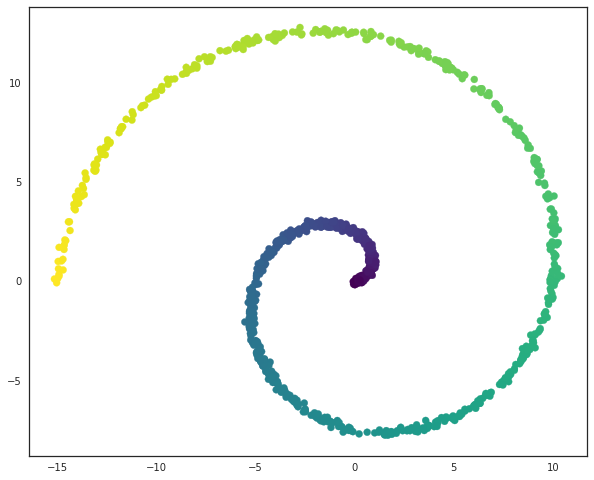

In [4]:
f, ax = plt.subplots(figsize=(10, 10))
plt.axes().set_aspect('equal')
idx = np.random.choice(int(np.floor((0.85)*n)), 1000)
plt.scatter(x_train[idx,0], 
            x_train[idx,1], 
            c=y_train[idx],
            cmap=plt.cm.viridis)

In [5]:
tf.reset_default_graph()

original_dim = [2]
latent_dim = 1
batch_size = 5000
clipNorm = 0.01
M = 3 # number of noise vectors
lr = 10**-4 # Learning Rate
epochs = 2500

noise_dims = [64, latent_dim]
a_phi_dims = [512, 256, 128]
theta_dims = [512, 256, 128]
psi_dims = [512, 512, 512]

eps_std = 1.

x = tf.placeholder(tf.float32, [batch_size] + original_dim, name='x')
z = tf.random_normal([batch_size, latent_dim], dtype=tf.float32, name="z")

## Adaptive Contrast ##
- Using "Adaptive Contrast" from the paper
    - Allows us to compare the current inference model to an adaptive distribution instead of the prior $p(z)$
    - Estimate moments of inference model
    - Generate $m$ noise vectors ($\epsilon$)
    - Each noise vector is passed through a small NN producing a vector with same dimensionality as latent space ... $v_{i,k}(\epsilon)$
    - Another set of NNs are used to estimate $m$ coefficients from the input $x$ .... $a_i(x)$
    - The latent space representation is a linear combination of the learned noise vectors using these coefficients
    
    $$z_k = \sum_{i=1}^m v_{i,k}(\epsilon_i )a_{i,k}(x)$$

In [6]:
# Adaptive distribution r_alpha(z | x)
# Generate noise vector nets
noise_basis = []

for i in range(M):
    phi_noise = slim.stack(tf.random_normal([batch_size, latent_dim], dtype=tf.float32, stddev=eps_std), 
                           slim.fully_connected, 
                           noise_dims, 
                           scope="phi_noise_basis_pre_{}".format(i))
    
    noise_basis.append(slim.fully_connected(phi_noise, 
                                            latent_dim, 
                                            activation_fn=None, 
                                            scope="phi_noise_basis_pre_{}".format(i)))
    
v_basis = tf.stack(noise_basis, axis=1, name="v_basis")  

a_phi_pre = slim.stack(x, slim.fully_connected, a_phi_dims, scope="phi_a_pre")

a_phis = tf.expand_dims(slim.fully_connected(a_phi_pre, 
                                             M, 
                                             activation_fn=None, 
                                             scope="phi_a"), axis=1)


## Inference ##
- Creates a latent representation of data

$$q_\phi\left( z \mid x\right)$$

- Moments of each $z$ are

$$ \mathbf{E}(z_k) = \sum_{i=1}^{m}\mathbf{E}[v_{i,k}(\epsilon_i)]a_{i,k}(x)$$

$$ \mathbf{Var}(z_k) = \sum_{i=1}^{m}\mathbf{Var}[v_{i,k}(\epsilon_i)]a_{i,k}(x)^2$$

In [7]:
# Inference model - q_phi(z | x)
# Linear combination of the noise basis vectors from above
z_phi = tf.squeeze(tf.matmul(a_phis, v_basis), axis=1, name="z_phi") 

# Moments estimated from minibatch - for each noise basis vector
alpha_mini_mu = tf.reduce_mean(v_basis, axis=0, name="alpha_mini_mu")
alpha_mini_sigma = tf.reduce_mean( (v_basis - alpha_mini_mu)**2 , axis=0, name="alpha_mini_sigma") # variance - should be sigma2

# Estimate moments of current inference model for x
alpha_mu_x = tf.reduce_sum(alpha_mini_mu * tf.transpose(a_phis, perm=[0,2,1]), axis=1, name="alpha_mu_x")
alpha_sigma_x = tf.reduce_sum(alpha_mini_sigma * tf.transpose(a_phis, perm=[0,2,1])**2, axis=1, name="alpha_sigma_x")

# Z-score transform it
z_hat = tf.identity((z_phi - alpha_mu_x) / tf.sqrt(alpha_sigma_x), name="z_hat_phi")

## Generative ##
- Reconstruct original from latent space representation
$$p_\theta(x \mid z) $$

In [8]:
theta_x_gen_pre = slim.stack(z_phi, 
                             slim.fully_connected, 
                             theta_dims,
                             scope="theta_x_gen_pre")

theta_x_gen = tf.reshape(slim.fully_connected(theta_x_gen_pre, 
                                   np.prod(original_dim),
                                   activation_fn=None, 
                                   scope="theta_x_gen"), [batch_size] + original_dim)

## Discriminator ##
- Tries to distinguish generated from real pairs of $x$ and $z$
- $\text{z_hat}$ is the Z-score transformed version of $z$ generated by the inference model
- That way, the discriminator just compares this to the multivariate Gaussian

In [9]:
# Output on generated samples

T_psi_generated_pre = slim.stack(tf.concat([x, z_hat], axis=1), 
                                 slim.fully_connected, 
                                 psi_dims,
                                 scope="T_psi_pre")

T_psi_generated = slim.fully_connected(T_psi_generated_pre, 
                                       1, 
                                       activation_fn=None, 
                                       scope="T_psi")

# Output on real samples

T_psi_real_pre = slim.stack(tf.concat([x, z], axis=1), 
                                 slim.fully_connected, 
                                 psi_dims,
                                 reuse=True,
                                 scope="T_psi_pre")

T_psi_real = slim.fully_connected(T_psi_real_pre, 
                                       1, 
                                       reuse=True,
                                       activation_fn=None, 
                                       scope="T_psi")

## Losses and Optimizer ##
- These are negated from the paper so we can apply gradient descent
- $p(x\mid z)$
- We use reconstruction error to estimate

In [10]:
loss_theta = tf.reduce_sum(tf.square(x - theta_x_gen), axis=1)
loss_phi = T_psi_generated + loss_theta 

loss_psi = -( tf.log(tf.sigmoid(T_psi_generated) + 10**-5) + tf.log(1 - tf.sigmoid(T_psi_real) + 10**-5 ) ) 

In [11]:
def compute_apply_grad(loss, keyword=None, learn_rate=0.001, clip_norm=0.01, **kwargs):
    """ Computes the gradients of variables matching keyword. Returns an optimizer"""
    opt = tf.train.AdamOptimizer(learning_rate=learn_rate, **kwargs)
    if keyword is None:
        cur_vars = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)]
    else:
        cur_vars = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if keyword in v.name]
    g = opt.compute_gradients(loss, cur_vars)
    g = [(tf.clip_by_norm(gr, clip_norm), v) for gr, v in g]
    optimize = opt.apply_gradients(g)
    return optimize

In [12]:
opt_theta = compute_apply_grad(loss_theta, learn_rate=lr, clip_norm=clipNorm, keyword="theta", epsilon=10**-4)
opt_phi = compute_apply_grad(loss_phi, learn_rate=lr, clip_norm=clipNorm, keyword="phi", epsilon=10**-4)
opt_psi = compute_apply_grad(loss_psi, learn_rate=lr, clip_norm=clipNorm, keyword="psi", epsilon=10**-4)

## Training ##

In [13]:
avg_theta = tf.reduce_mean(loss_theta) # Over batch
avg_phi = tf.reduce_mean(loss_phi) 
avg_psi = tf.reduce_mean(loss_psi)

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
train_all = [opt_theta, opt_phi, opt_psi, avg_theta, avg_phi, avg_psi]
train_discriminator = [opt_psi, avg_theta, avg_phi, avg_psi]

In [16]:
saver = tf.train.Saver()
#saver.restore(sess, "data/avb_model_z1.ckpt")

In [ ]:
trainGen = datGen(x_train, batch_size)
perf = {'Theta': None, 'Phi': None, 'Psi': None}

try:
    for e in tnrange(epochs, desc='Overall Training', unit='epoch'):
        bperf = {'Theta': [], 'Phi': [], 'Psi': []}
        for i in tnrange(x_train.shape[0] // batch_size, postfix=perf, unit=' batches', desc="Epoch {}".format(e+1)):
            batch = trainGen.next()
            if i % 2 == 1:
                # Train the inference and generative nets 
                _, _, _, at, ap, aps = sess.run(train_all, feed_dict={x: batch}) 
            else:
                # Train the discriminator every minibatch (try to get T closer to T* - the optimal T)
                _, at, ap, aps = sess.run(train_discriminator, feed_dict={x: batch})    

            bperf['Theta'].append(at)
            bperf['Phi'].append(ap)
            bperf['Psi'].append(aps)

        perf['Theta'] = np.mean(bperf['Theta'])
        perf['Phi'] = np.mean(bperf['Phi'])
        perf['Psi'] = np.mean(bperf['Psi'])
except KeyboardInterrupt:
    print "Terminated training"

In [52]:
save_path = saver.save(sess, "data/avb_model_z1.ckpt")

In [53]:
# Predict on some training data
test_idx = np.random.choice(np.arange(x_test.shape[0]), batch_size)
test_batch = x_test[test_idx, :]
test_y = y_test[test_idx]
pred_z, pred_x, pred_a, pred_t, pred_gen, pred_real, pred_loss_psi = sess.run(
    [z_phi, theta_x_gen, a_phis, v_basis, T_psi_generated, T_psi_real, loss_psi], 
                                          feed_dict={x: test_batch})
preds = pd.DataFrame(np.hstack([test_batch, pred_z, test_y[:, np.newaxis]]))
preds.columns = ['x1', 'x2'] + ['z' + str(i+1) for i in range(latent_dim)] + ['angle']

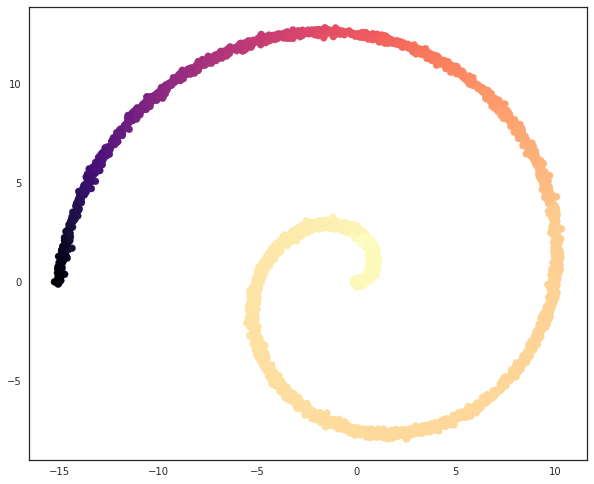

In [56]:
f, ax = plt.subplots(figsize=(10, 10))
plt.axes().set_aspect('equal')
plt.scatter(preds.x1, 
            preds.x2, 
            c=preds.z1,
            cmap=plt.cm.magma)
#d = plt.xlim((-10, 10))
#d = plt.ylim((-10, 10))
#l = plt.colorbar()